In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from DDGAUGAN import Predictor

2023-05-16 20:02:08.198634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 20:02:08.662508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/klima7/studies/project/code/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
predictor = Predictor('trained_models/image_generator_model.h5', 'trained_models/image_encoder_model.h5')

2023-05-16 20:02:10.601940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:02:10.616120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:02:10.616274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
generator = predictor.gen
sampler = predictor.sampler
encoder = predictor.encoder

In [4]:
generator.trainable = False

libpng warning: iCCP: known incorrect sRGB profile


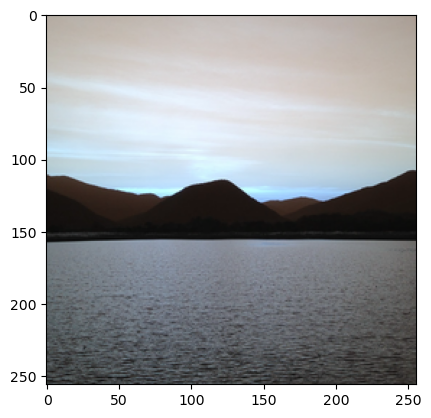

In [184]:
target_path = 'data/lhq/images/0000015.png'
target = cv2.imread(target_path)

plt.imshow(target)

target = target / 127.5 - 1
target = target[np.newaxis, ...]

In [129]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from skimage import io, transform, color
import requests
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from typing import List
from dataset import parse_csv
from tqdm import tqdm

In [130]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [134]:
import multiprocessing
import itertools
from typing import List
import numpy as np
import pandas as pd
from glob import glob

def parse_csv(path: str = 'data/included_classes.csv', sep: str = ';'):
    csv = pd.read_csv(path, sep=sep)
    classes = {}
    for index, (name, inc) in enumerate(zip(csv['Name'], csv['Include'])):
        if inc:
            classes[name] = index
    return classes 

In [207]:
def image_to_mask(images, model, feature_extractor) -> List[np.ndarray]:
    inputs = feature_extractor(images=images, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    data: np.ndarray = np.array(logits.detach().numpy()).transpose((0, 2, 3, 1))
    image_mask = np.argmax(data, axis=-1, keepdims=True)
    return image_mask.astype(np.uint8)

def read_images(paths):
    return [io.imread(p) for p in paths]

classes = parse_csv()

In [189]:
target = np.transpose(target, [0, 3, 1, 2])

In [190]:
target.shape, target.dtype

((1, 3, 256, 256), dtype('float64'))

In [208]:
i = np.random.randn(256, 256, 3)
labels = image_to_mask([i, i, i, i, i, i], model, feature_extractor)
labels.shape

torch.Size([6, 150, 128, 128])


(6, 128, 128, 1)

In [179]:
labels.shape

(1, 128, 128, 1)

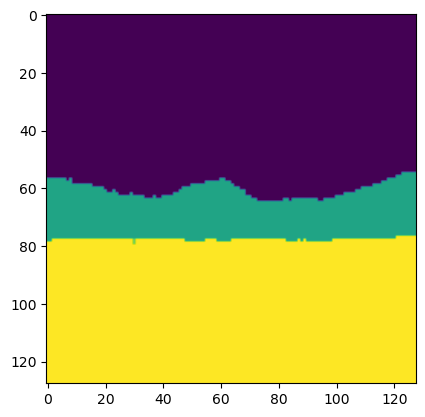

In [173]:
plt.imshow(labels[0])

In [160]:
map = labels[0]

In [161]:
import numpy as np
import cv2
from tqdm import tqdm
from tqdm import tqdm
from dataset import generate_colors
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, maximum_filter

fmaps = cv2.medianBlur(map, 13)[..., np.newaxis]
unique, counts = np.unique(fmaps, return_counts=True)
pmax_val = unique[np.argmax(counts)]
for u, c in zip(unique, counts):
    if c < 1000:
        fmaps[fmaps == u] = 0
fmaps = maximum_filter(fmaps, 5)            
    

In [166]:
fmaps.shape, fmaps.dtype, fmaps.min(), fmaps.max()

((128, 128, 1), dtype('uint8'), 2, 26)

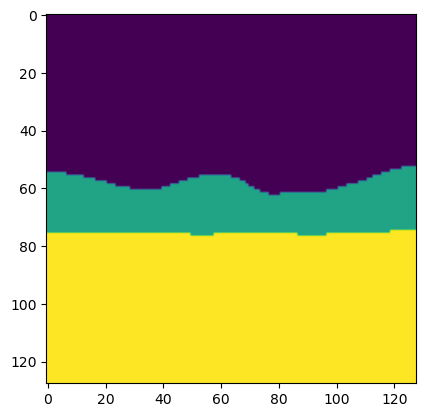

In [164]:
plt.imshow(fmaps)

In [118]:
# noise = tf.Variable(initial_value=tf.random.normal(shape=(1, 256)), trainable=True)
labels = tf.Variable(initial_value=tf.random.normal(shape=(1, 256, 256, 25)), trainable=True)
noise = tf.random.normal((1, 256))

In [ ]:
from GAUGAN import VGGFeatureMatchingLoss
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

num_iterations = 100_000

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

perceptual_loss = VGGFeatureMatchingLoss()
# perceptual_loss.vgg_model = perceptual_loss.vgg_model.float()
mse_loss = MeanAbsoluteError()

mse_weight = 1
perceptual_weight = 0

iterator = tqdm(range(num_iterations))
for iteration in iterator:
    with tf.GradientTape() as tape:
        prediction = generator([noise, labels])
        # loss_value = tf.reduce_sum(tf.square(prediction - target))
        # perceptual = perceptual_loss(prediction, target)
        # perceptual = tf.cast(perceptual, dtype=tf.float64)
        perceptual = 0
        mse = mse_loss(prediction, target)
        
        loss_value = mse_weight * mse + perceptual_weight * perceptual
        
    gradients = tape.gradient(loss_value, [labels])
    optimizer.apply_gradients(zip(gradients, [labels]))
    
    iterator.set_postfix_str(f'Loss: {loss_value.numpy()}')
    if iteration % 100 == 0:
        learned_image = (generator([noise, labels]) + 1) * 127.5
        learned_image = np.array(learned_image, np.uint8)
        plt.imshow(learned_image[0])
        plt.show()

In [122]:
noise_np = noise.numpy()
labels_np = labels.numpy()

In [93]:
np.save('noise2.npy', noise_np)
np.save('labels2.npy', labels_np)

In [81]:
noise_np = np.load('noise.npy')
labels_np = np.load('labels.npy')

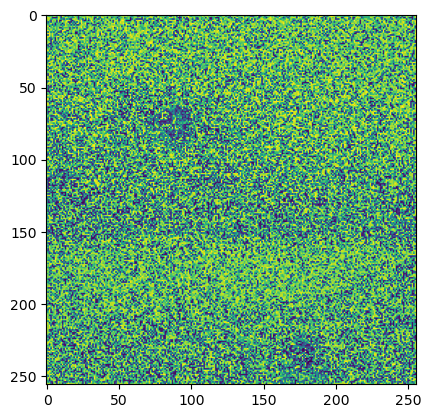

In [123]:
l = labels_np.argmax(axis=-1)
plt.imshow(l[0])

In [126]:
import numpy as np
from PIL import Image
from scipy.ndimage import generic_filter
from scipy import stats

def modal(P):
    mode = stats.mode(P)
    return mode.mode[0]

# Run modal filter
result = generic_filter(l[0], modal, (16, 16))

/tmp/ipykernel_1154252/3227853642.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(P)


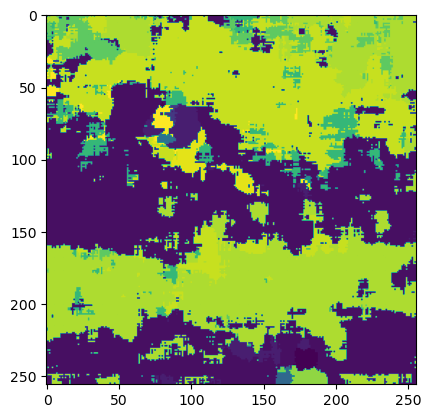

In [127]:
plt.imshow(result)

In [97]:
labels_np.shape

(1, 256, 256, 25)

In [102]:
labels_np[0, 150:200, 100:150, :] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

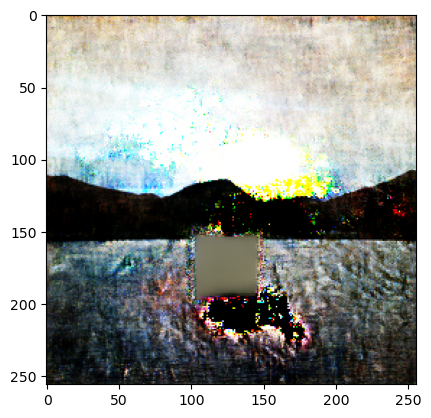

In [103]:
learned_image = (generator([noise_np, labels_np]) + 1) * 127.5
learned_image = np.array(learned_image, np.uint8)
plt.imshow(learned_image[0])